In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import (
    v_measure_score,
    silhouette_score,
    davies_bouldin_score,
    homogeneity_score,
    rand_score,
    adjusted_rand_score,
)
from sklearn.impute import SimpleImputer
import io
from IPython.display import clear_output
from datetime import datetime, timedelta

# Simulation et détermination de la fréquence de mise à jour

In [8]:
def customers_dataset(orders_model, start_date, end_date):
    """
    Cette fonction permet de passer du dataset des commandes à celui des clients en exploitant le customer_id
    et le customer_unique_id.
    Les deux paramètres start_date et end_date permet de limiter les commande à celle ayant été réalisée entre ces
    deux dates.
    """
    # Filtrage sur la période souhaitée
    orders_update = orders_model[
        (orders_model["order_purchase_timestamp"] < end_date)
        & (orders_model["order_purchase_timestamp"] >= start_date)
    ]
    # Importation du dataset contenant les informations sur les clients
    customers = pd.read_csv(r"data/olist_customers_dataset.csv", encoding="utf-8")
    # Récupération des commandes réalisée par les clients
    customers = customers.merge(
        orders_update[
            [
                "customer_id",
                "order_purchase_timestamp",
                "payment_value",
                "payment_installments",
                "review_score",
            ]
        ],
        how="right",
        on=["customer_id"],
    )

    most_recent_date = orders_update[
        "order_purchase_timestamp"
    ].max()  # date de la commande la plus récente
    customers["recency_customer"] = (
        most_recent_date - customers["order_purchase_timestamp"]
    ).apply(lambda ts: ts.days)
    # Passage à une vision client unique.
    customers = customers.groupby(["customer_unique_id"]).agg(
        {
            "recency_customer": "mean",
            "customer_id": lambda x: len(np.unique(x)),
            "payment_value": "sum",
            "payment_installments": "mean",
            "review_score": "mean",
        }
    )
    customers = customers.rename(columns={"customer_id": "number_of_orders"})
    # Imputation des données manquantes
    customers["payment_installments"] = customers["payment_installments"].fillna(1)
    customers["review_score"] = customers["review_score"].fillna(
        customers["review_score"].mean()
    )
    customers = customers.reset_index()
    return customers

In [5]:
# Jointure entre le dataset des commandes, celui des payements, des produits et des notes de satisfactions.

# importations
orders = pd.read_csv(r"data/olist_orders_dataset.csv", encoding="utf-8")
order_items = pd.read_csv(r"data/olist_order_items_dataset.csv", encoding="utf-8")
order_payments = pd.read_csv(r"data/olist_order_payments_dataset.csv", encoding="utf-8")
order_reviews = pd.read_csv(r"data/olist_order_reviews_dataset.csv", encoding="utf-8")
products = pd.read_csv(r"data/olist_products_dataset.csv", encoding="utf-8")
category_translation = pd.read_csv(
    r"data/product_category_name_translation.csv", encoding="utf-8"
)

# Jointures
orders_1 = orders.merge(order_items, on=["order_id"], how="left")
orders_2 = orders_1.merge(order_payments, on=["order_id"], how="left")
orders_3 = orders_2.merge(order_reviews, on=["order_id"], how="left")
orders_4 = orders_3.merge(products, on=["product_id"], how="left")

# Traduction des catégories de produits
orders_4["product_category_name_english"] = orders_4["product_category_name"].map(
    category_translation.set_index("product_category_name")[
        "product_category_name_english"
    ]
)
orders_4 = orders_4.drop(columns=["product_category_name"])
orders_4 = orders_4.rename(
    columns={"product_category_name_english": "product_category_name"}
)

orders_info = orders_4

In [6]:
# Selection des variables pertinentes pour la segmentation client.
to_keep = [
    "order_id",
    "customer_id",
    "order_purchase_timestamp",
    "freight_value",
    "payment_value",
    "payment_installments",
    "review_score",
    "review_comment_message",
]
orders_model = orders_info[to_keep].copy(deep=True)
orders_model["order_purchase_timestamp"] = orders_model[
    "order_purchase_timestamp"
].apply(pd.to_datetime)

In [12]:
def standardize(dataset):
    from sklearn.preprocessing import StandardScaler
    vtype ={'customer_unique_id':'num',
        'geolocation_lat':'num',
        'geolocation_lng':'num',
        'freight_value':'num',
        'payment_value':'num',
        'payment_installments':'num',
        'review_score':'num',
        'review_comment':'cat',
        'number_of_orders':'num',
        'number_of_items':'num',
        'recency_customer':'num',
        'credit_card':'cat',
        'voucher':'cat',
        'boleto':'cat',
        'debit_card':'cat',
        'not_defined':'cat',
        'home':'cat',
        'beauty':'cat', 
        'office':'cat',
        'multimedia':'cat',
        'children':'cat',
        'construction':'cat',
        'fashion':'cat',
        'sport':'cat',
        'books':'cat',
        'food':'cat',
        'industry':'cat',
        'other':'cat',
        'unknown':'cat'}
    num_col = []
    cat_col = []
    for var in dataset.columns:
        if vtype[var]=='num':
            num_col.append(var)
        else:
            cat_col.append(var)
    X_num = dataset[num_col].values
    X_cat = dataset[cat_col].values
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X_num)
    X_scaled = np.concatenate((X_num_scaled, X_cat), axis = 1) 
    return X_scaled

def standardize_0(dataset):
    from sklearn.preprocessing import StandardScaler
    vtype ={'customer_unique_id':'num',
        'geolocation_lat':'num',
        'geolocation_lng':'num',
        'freight_value':'num',
        'payment_value':'num',
        'payment_installments':'num',
        'review_score':'num',
        'review_comment':'cat',
        'number_of_orders':'num',
        'number_of_items':'num',
        'recency_customer':'num',
        'credit_card':'cat',
        'voucher':'cat',
        'boleto':'cat',
        'debit_card':'cat',
        'not_defined':'cat',
        'home':'cat',
        'beauty':'cat', 
        'office':'cat',
        'multimedia':'cat',
        'children':'cat',
        'construction':'cat',
        'fashion':'cat',
        'sport':'cat',
        'books':'cat',
        'food':'cat',
        'industry':'cat',
        'other':'cat',
        'unknown':'cat'}
    num_col = []
    cat_col = []
    for var in dataset.columns:
        if vtype[var]=='num':
            num_col.append(var)
        else:
            cat_col.append(var)
    X_num = dataset[num_col].values
    X_cat = dataset[cat_col].values
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X_num)
    X_scaled = np.concatenate((X_num_scaled, X_cat), axis = 1) 
    return scaler, X_scaled

In [14]:
# Entraînement du modèle M_0 sur le dataset_0
first_date = orders_model["order_purchase_timestamp"].min()
update_date = first_date + timedelta(days=180)
last_date = orders_model["order_purchase_timestamp"].max()
# complete_dataset = customers_dataset(orders_model, first_date,last_date+timedelta(seconds=1))
dataset_0 = customers_dataset(orders_model, first_date, update_date)[
    [
        "recency_customer",
        "number_of_orders",
        "payment_value",
        "payment_installments",
        "review_score",
    ]
]
scaler_0, X_scaled_0 = standardize_0(dataset_0)
kmeans_0 = KMeans(n_clusters=5).fit(X_scaled_0)

In [15]:
# Tracé de l'évolution du score ARI entre le dataset_0 et le dataset_i (à date) en fonction de la fréquence de mise à jour.
frequency = ["W", "SM", "MS", "Q", "YS"]
ari_scores = []
for d in pd.date_range(str(update_date), str(last_date), freq="W"):
    df = dataset_0[
        [
            "recency_customer",
            "number_of_orders",
            "payment_value",
            "payment_installments",
            "review_score",
        ]
    ]
    dataset_i = customers_dataset(orders_model, update_date, d + timedelta(seconds=1))[
        [
            "recency_customer",
            "number_of_orders",
            "payment_value",
            "payment_installments",
            "review_score",
        ]
    ]
    df = df.append(dataset_i).reset_index(drop=True)
    X = df.values
    X_scaled_i_scaler_0 = scaler_0.transform(X)
    scaler_i = StandardScaler()
    X_scaled_i_scaler_i = scaler_i.fit_transform(X)
    labels_0 = kmeans_0.predict(X_scaled_i_scaler_0)
    labels_i = KMeans(n_clusters=5).fit(X_scaled_i_scaler_i).labels_
    ari = adjusted_rand_score(labels_0, labels_i)
    ari_scores.append(ari)
    clear_output()

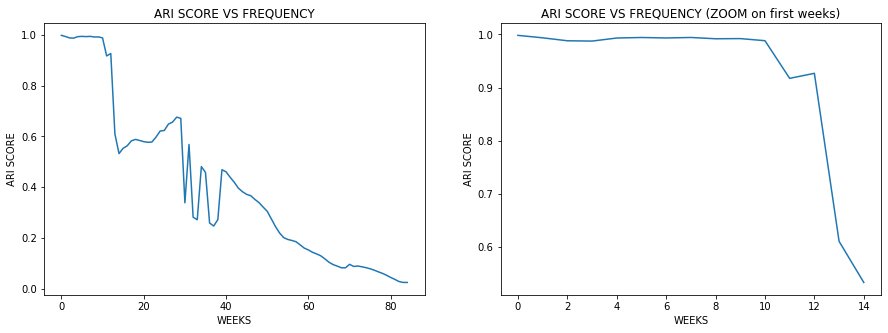

In [16]:
# Tracé de l'évolution du score ARI entre le dataset_0 et le dataset_i (à date) en fonction de la fréquence de mise à jour.
n = 15
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(range(len(ari_scores)), ari_scores, linestyle="-")
ax[0].set_title("ARI SCORE VS FREQUENCY")
ax[0].set_xlabel("WEEKS")
ax[0].set_ylabel("ARI SCORE")
ax[1].plot(range(len(ari_scores[:n])), ari_scores[:n], linestyle="-")
ax[1].set_title("ARI SCORE VS FREQUENCY (ZOOM on first weeks)")
ax[1].set_xlabel("WEEKS")
ax[1].set_ylabel("ARI SCORE")
plt.show()